In [1]:
#Import necessary libraries 
import pandas as pd 
import numpy as np
import re
from scipy import sparse 
from pandas.api.types import CategoricalDtype 
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

In [2]:
#Kaggle Datasets
aday_log=pd.read_csv('../input/datathon-guess-the-last-one/data_aday_log.csv')
cv_details=pd.read_csv('../input/datathon-guess-the-last-one/data_cv_details.csv')
job_details=pd.read_csv('../input/datathon-guess-the-last-one/data_job_details.csv')
#sample=pd.read_csv('../input/datathon-guess-the-last-one/sample_.csv')
son2_basvuranlar_test=pd.read_csv('../input/datathon-guess-the-last-one/son2_basvurular_test.csv')

In [3]:
cv_log_merge=pd.merge(aday_log,cv_details,how='left',on='jobseekerId')
cv_job_merge=pd.merge(cv_log_merge,job_details,how='left',on='jobId')
cv_job_merge=cv_job_merge.drop(labels=['Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0'],axis=1)
cv_job_merge.head()

,jobseekerId,jobId,applicationDate,jobseekerCity,jobseekerLastPosition,departmentName,totalExperienceYear,jobPosition,jobDescription,jobCity,minExperience,maxExperience
0,9133,2647244,2021-01-03 18:29:31.383,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><strong>GENEL NİTELİKLE...",İstanbul(Avr.),99,99
1,9133,2575774,2021-01-03 20:46:26.693,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,<p>- Genel Muhasebe alanında en az 7 yıl ve üz...,İstanbul(Asya),99,99
2,9133,2614546,2021-01-03 20:48:02.357,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><span>Turizm Sektöründe...",İstanbul(Asya),15,0
3,9133,2649353,2021-01-06 19:10:03.800,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Finans Müdürü,<p></p><p><strong><u>Genel Nitelikler</u></str...,İstanbul(Asya),7,0
4,9133,2621592,2021-01-07 10:32:55.957,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Sorumlusu,"<p class=""x_x_x_x_x_MsoNormal""><span>Sektöründ...",İstanbul(Asya),5,0


In [4]:
#EXPERIENCE KARSILASTIRMA
cv_job_merge['minExperience']=np.where(cv_job_merge.minExperience==99,0,cv_job_merge.minExperience)
cv_job_merge['maxExperience']=np.where(cv_job_merge.maxExperience==0,99,cv_job_merge.maxExperience)

cv_job_merge['minExperience']=np.where(cv_job_merge.minExperience.isin([96,97,98]),0,cv_job_merge.minExperience)
cv_job_merge['maxExperience']=np.where(cv_job_merge.maxExperience.isin([96,97,98]),2,cv_job_merge.maxExperience)

In [5]:
cv_job_merge['EnoughExp']=np.where( (cv_job_merge.minExperience <= cv_job_merge.totalExperienceYear) & (cv_job_merge.totalExperienceYear <= cv_job_merge.maxExperience),1,0)
cv_job_merge.head()

,jobseekerId,jobId,applicationDate,jobseekerCity,jobseekerLastPosition,departmentName,totalExperienceYear,jobPosition,jobDescription,jobCity,minExperience,maxExperience,EnoughExp
0,9133,2647244,2021-01-03 18:29:31.383,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><strong>GENEL NİTELİKLE...",İstanbul(Avr.),0,99,1
1,9133,2575774,2021-01-03 20:46:26.693,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,<p>- Genel Muhasebe alanında en az 7 yıl ve üz...,İstanbul(Asya),0,99,1
2,9133,2614546,2021-01-03 20:48:02.357,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><span>Turizm Sektöründe...",İstanbul(Asya),15,99,1
3,9133,2649353,2021-01-06 19:10:03.800,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Finans Müdürü,<p></p><p><strong><u>Genel Nitelikler</u></str...,İstanbul(Asya),7,99,1
4,9133,2621592,2021-01-07 10:32:55.957,İstanbul(Asya),Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Sorumlusu,"<p class=""x_x_x_x_x_MsoNormal""><span>Sektöründ...",İstanbul(Asya),5,99,1


In [6]:
#City Control
cv_job_merge.jobseekerCity=cv_job_merge.jobseekerCity.apply(lambda x:re.sub("[\(\[].*?[\)\]]", "", x))
cv_job_merge.jobCity=cv_job_merge.jobCity.apply(lambda x:re.sub("[\(\[].*?[\)\]]", "", x))

In [7]:
cv_job_merge['city_control'] = cv_job_merge.apply(lambda x: x.jobseekerCity in x.jobCity, axis=1)
cv_job_merge.head()

,jobseekerId,jobId,applicationDate,jobseekerCity,jobseekerLastPosition,departmentName,totalExperienceYear,jobPosition,jobDescription,jobCity,minExperience,maxExperience,EnoughExp,city_control
0,9133,2647244,2021-01-03 18:29:31.383,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><strong>GENEL NİTELİKLE...",İstanbul,0,99,1,True
1,9133,2575774,2021-01-03 20:46:26.693,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,<p>- Genel Muhasebe alanında en az 7 yıl ve üz...,İstanbul,0,99,1,True
2,9133,2614546,2021-01-03 20:48:02.357,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><span>Turizm Sektöründe...",İstanbul,15,99,1,True
3,9133,2649353,2021-01-06 19:10:03.800,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Finans Müdürü,<p></p><p><strong><u>Genel Nitelikler</u></str...,İstanbul,7,99,1,True
4,9133,2621592,2021-01-07 10:32:55.957,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Sorumlusu,"<p class=""x_x_x_x_x_MsoNormal""><span>Sektöründ...",İstanbul,5,99,1,True


In [8]:
cv_position_merge=cv_job_merge.groupby(['jobseekerId','jobPosition'],as_index=False).jobId.count().sort_values(by=['jobseekerId','jobId'], ascending=[True,False]).groupby('jobseekerId',as_index=False).head(1)
cv_position_merge.head(5)

,jobseekerId,jobPosition,jobId
7,9133,Muhasebe Müdürü,8
15,10567,Proje Müdürü,2
27,16042,İnşaat Mühendisi,3
30,25661,Bölge Müdürü,1
46,28168,Satış Müdürü,2


In [9]:
cv_job_merge=pd.merge(cv_job_merge,cv_position_merge,how='left',on='jobseekerId')
cv_job_merge.head()

,jobseekerId,jobId_x,applicationDate,jobseekerCity,jobseekerLastPosition,departmentName,totalExperienceYear,jobPosition_x,jobDescription,jobCity,minExperience,maxExperience,EnoughExp,city_control,jobPosition_y,jobId_y
0,9133,2647244,2021-01-03 18:29:31.383,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><strong>GENEL NİTELİKLE...",İstanbul,0,99,1,True,Muhasebe Müdürü,8
1,9133,2575774,2021-01-03 20:46:26.693,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,<p>- Genel Muhasebe alanında en az 7 yıl ve üz...,İstanbul,0,99,1,True,Muhasebe Müdürü,8
2,9133,2614546,2021-01-03 20:48:02.357,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><span>Turizm Sektöründe...",İstanbul,15,99,1,True,Muhasebe Müdürü,8
3,9133,2649353,2021-01-06 19:10:03.800,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Finans Müdürü,<p></p><p><strong><u>Genel Nitelikler</u></str...,İstanbul,7,99,1,True,Muhasebe Müdürü,8
4,9133,2621592,2021-01-07 10:32:55.957,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Sorumlusu,"<p class=""x_x_x_x_x_MsoNormal""><span>Sektöründ...",İstanbul,5,99,1,True,Muhasebe Müdürü,8


In [10]:
#Job Position Rule
cv_job_merge['jobPosition_rule']=np.where( (cv_job_merge.jobseekerLastPosition==cv_job_merge.jobPosition_x) |(cv_job_merge.jobPosition_x==cv_job_merge.jobPosition_y) ,1,0)
cv_job_merge.head()

,jobseekerId,jobId_x,applicationDate,jobseekerCity,jobseekerLastPosition,departmentName,totalExperienceYear,jobPosition_x,jobDescription,jobCity,minExperience,maxExperience,EnoughExp,city_control,jobPosition_y,jobId_y,jobPosition_rule
0,9133,2647244,2021-01-03 18:29:31.383,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><strong>GENEL NİTELİKLE...",İstanbul,0,99,1,True,Muhasebe Müdürü,8,1
1,9133,2575774,2021-01-03 20:46:26.693,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,<p>- Genel Muhasebe alanında en az 7 yıl ve üz...,İstanbul,0,99,1,True,Muhasebe Müdürü,8,1
2,9133,2614546,2021-01-03 20:48:02.357,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Müdürü,"<p class=""x_MsoNormal""><span>Turizm Sektöründe...",İstanbul,15,99,1,True,Muhasebe Müdürü,8,1
3,9133,2649353,2021-01-06 19:10:03.800,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Finans Müdürü,<p></p><p><strong><u>Genel Nitelikler</u></str...,İstanbul,7,99,1,True,Muhasebe Müdürü,8,0
4,9133,2621592,2021-01-07 10:32:55.957,İstanbul,Mali Danışman,Çalışma Ekonomisi ve Endüstri İlişkileri,24,Muhasebe Sorumlusu,"<p class=""x_x_x_x_x_MsoNormal""><span>Sektöründ...",İstanbul,5,99,1,True,Muhasebe Müdürü,8,0


<AxesSubplot:>

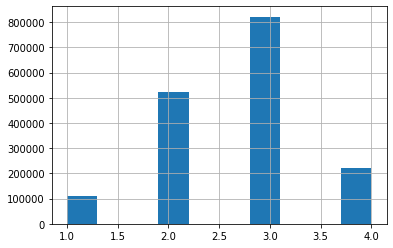

In [11]:
#Combining all ratings into one and distribution of the rating among the jobseekers
cv_job_merge['rating']=1+cv_job_merge.EnoughExp+cv_job_merge.city_control+cv_job_merge.jobPosition_rule
df=cv_job_merge[['jobId_x','jobseekerId','rating']]
df.rating.hist()

In [12]:
df['jobId_x'] = 'I' + df['jobId_x'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
jobId = list(np.sort(df.jobId_x.unique())) 
jobseekerId = list(np.sort(df.jobseekerId.unique()))
rating = list(df.rating)


cols = df.jobseekerId.astype(CategoricalDtype(categories=jobseekerId)).cat.codes 

rows = df.jobId_x.astype(CategoricalDtype(categories= jobId)).cat.codes 
# Get the associated column indices 
#Compressed Sparse Row matrix 
sparse_data = sparse.csr_matrix((rating, (rows, cols)), shape=(len(jobId),len(jobseekerId))) 
sparse_data

<33992x103896 sparse matrix of type '<class 'numpy.int64'>'
	with 1673959 stored elements in Compressed Sparse Row format>

In [17]:
user_label_encoder = LabelEncoder()
user_ids = user_label_encoder.fit_transform(df.jobseekerId)
product_label_encoder = LabelEncoder()
product_ids = product_label_encoder.fit_transform(df.jobId_x)
# compute recommendations


similarity = cosine_similarity(sparse_data,dense_output=False)
test=user_label_encoder.transform(son2_basvuranlar_test.jobseekerId.unique())

In [18]:
CustomerSalesItemMatrix = csr_matrix(sparse_data.T)

In [19]:
CustomerSalesItemScores = CustomerSalesItemMatrix.dot(similarity) 

# sum of similarities to all purchased products

In [20]:
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
aday_log                DataFrame             Unnamed: 0  jobs<...>1673959 rows x 4 columns]
cv_details              DataFrame            Unnamed: 0  jobse<...>[194877 rows x 6 columns]
cv_job_merge            DataFrame             jobseekerId  job<...>673959 rows x 18 columns]
cv_log_merge            DataFrame             Unnamed: 0_x  jo<...>1673959 rows x 9 columns]
cv_position_merge       DataFrame             jobseekerId     <...>[103896 rows x 3 columns]
df                      DataFrame              jobId_x  jobsee<...>1673959 rows x 3 columns]
job_details             DataFrame           Unnamed: 0    jobI<...>n[39477 rows x 7 columns]
son2_basvuranlar_test   DataFrame            jobseekerId  jobI<...>[115598 rows x 2 columns]


In [21]:
#Delete some df for space
del aday_log,cv_details,cv_job_merge,cv_log_merge,cv_position_merge,df,job_details

In [23]:
CustomerSalesItemScores

<103896x33992 sparse matrix of type '<class 'numpy.float64'>'
	with 1047818214 stored elements in Compressed Sparse Row format>

In [24]:
RecForCust = pd.DataFrame()
for user_id in range(CustomerSalesItemScores.shape[0]):
    scores = CustomerSalesItemScores[user_id, :].toarray().flatten()
    purchased_items = CustomerSalesItemMatrix.indices[CustomerSalesItemMatrix.indptr[user_id]:
                                                      CustomerSalesItemMatrix.indptr[user_id+1]]
    scores[purchased_items] = -1 # do not recommend already purchased SalesItems
    top_products_ids = np.argsort(scores)[-10:][::-1]
    recommendations = pd.DataFrame(top_products_ids.reshape(1, -1),
                                   index=[user_id],
                                   columns=['Top%s' % (i+1) for i in range(10)])
    RecForCust=RecForCust.append(recommendations)

In [25]:
RecForCust.index = user_label_encoder.inverse_transform(RecForCust.index)
for i in range(RecForCust.shape[1]):
    RecForCust.iloc[:, i] = product_label_encoder.inverse_transform(RecForCust.iloc[:, i])

In [26]:
RecForCust.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10
9133,I2369581,I2646667,I2653618,I2650494,I2647321,I2647551,I2655317,I2653180,I2646416,I2654889
10567,I2639389,I2649944,I2648411,I2641545,I2639862,I2639975,I2646669,I2641108,I2651088,I2636764
16042,I2647264,I2655143,I2650463,I2653260,I2655710,I2649197,I2652830,I2651812,I2524622,I2648306
25661,I2652341,I2651183,I2647251,I2655291,I2647191,I2649583,I2650926,I2647167,I2648429,I2653750
28168,I2646585,I2650027,I2650013,I2647813,I2646825,I2648280,I2650378,I2647300,I2652159,I2654683


In [27]:
submission=RecForCust.reset_index().melt(id_vars=['index'],value_name='jobId')
submission.head()

,index,variable,jobId
0,9133,Top1,I2369581
1,10567,Top1,I2639389
2,16042,Top1,I2647264
3,25661,Top1,I2652341
4,28168,Top1,I2646585


In [28]:
submission=submission[['index','jobId']].rename(columns={'index':'jobseekerId','jobId':'jobId'})
submission.jobId=submission.jobId.str.replace('I','')

In [29]:
submission=submission.sort_values(by='jobseekerId')

In [34]:
final_submission=submission[submission.jobseekerId.isin(son2_basvuranlar_test.jobseekerId.unique())]

In [35]:
final_submission.to_csv('rating_based_cosine_sim_submissionv2.csv',index=False)